# Project 2: Ames Housing Data and Kaggle Challenge

## Part II - Modeling

Author: Charles Ramey

Date: 03/19/2023

---

#### Links

For the first and third iterations, see the following notebooks:
- [`Part-2.1_model-iteration-1.ipynb`](../code/Part-2.1_model-iteration-1.ipynb)
- [`Part-2.3_model-iteration-3.ipynb`](../code/Part-2.3_model-iteration-3.ipynb)

To see the conclusions and recommendations of this project, see the following notebook:
- [`Part-3_conclusion-and-recommendations.ipynb`](../code/Part-3_conclusion-and-recommendations.ipynb)

### Contents

- [Preprocessing](#Preprocessing)
- [Linear Model](#Linear-Model)
- [Ridge Model](#Ridge-Model)
- [Lasso Model](#Lasso-Model)
- [ElasticNet Model](#ElasticNet-Model)
- [Predictions](#Predictions)

## Model Iteration 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config

import warnings

In [2]:
set_config(transform_output='pandas')

In [3]:
df_train = pd.read_csv('../datasets/train_cleaned.csv')
df_test = pd.read_csv('../datasets/test_cleaned.csv')
df_train

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,13517,Pave,IR1,Lvl,AllPub,CulDSac,...,44,0,0,0,0,0,3,2010,WD,130500
1,544,531379050,60,RL,11492,Pave,IR1,Lvl,AllPub,CulDSac,...,74,0,0,0,0,0,4,2009,WD,220000
2,153,535304180,20,RL,7922,Pave,Reg,Lvl,AllPub,Inside,...,52,0,0,0,0,0,1,2010,WD,109000
3,318,916386060,60,RL,9802,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2010,WD,174000
4,255,906425045,50,RL,14235,Pave,IR1,Lvl,AllPub,Inside,...,59,0,0,0,0,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,11449,Pave,IR1,HLS,AllPub,Inside,...,276,0,0,0,0,0,1,2008,WD,298751
2047,785,905377130,30,RL,12342,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,0,3,2009,WD,82500
2048,916,909253010,50,RL,7558,Pave,Reg,Bnk,AllPub,Inside,...,0,0,0,0,0,0,3,2009,WD,177000
2049,639,535179160,20,RL,10400,Pave,Reg,Lvl,AllPub,Corner,...,189,140,0,0,0,0,11,2009,WD,144000


### Preprocessing & Feature Engineering

After creating simple models in the first iteration, we are going to include a wider selection of features in the second iteration. This time, many of the features included in the analysis will contain categorical data. Of the categorical data, some will need to be [one-hot encoded](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), and some will need to be [ordinal encoded](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). For example, the `street` feature contains two possible categories, paved and gravel, which will need to be one-hot encoded, whereas `exter_qual` (exteriror quality), contains five possible ordered categories: poor, fair, typical, good, and excellent.

In [4]:
df_train['street'].unique()

array(['Pave', 'Grvl'], dtype=object)

In [5]:
df_train['exter_qual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [6]:
# features to be OneHotEncoded
feats_for_ohe = ['street', 'utilities', 'lot_config', 'neighborhood', 'bldg_type',
                'roof_matl', 'exterior_1st', 'heating', 'central_air','paved_drive',
                ]
# features to be OrdinalEncoded
feats_for_oenc = ['land_slope', 'overall_qual', 'overall_cond', 'exter_qual',
                 'exter_cond', 'heating_qc', 'kitchen_qual']

Above, the features designated for one-hot encoding and ordinal encoding are defined in lists to be easily called when the data is transformed.

Below, the `OrdinalEncoder()` is initialized with all of the possible categories for each categorical feature in `feats_for_oenc`.

In [7]:
oenc = OrdinalEncoder(categories = [
    ['Gtl','Mod','Sev'],
    [1,2,3,4,5,6,7,8,9,10],
    [1,2,3,4,5,6,7,8,9,10],
    ['Po','Fa','TA','Gd','Ex'],
    ['Po','Fa','TA','Gd','Ex'],
    ['Po','Fa','TA','Gd','Ex'],
    ['Po','Fa','TA','Gd','Ex']]
)

In [8]:
df_train_oenc = oenc.fit_transform(df_train[feats_for_oenc])
df_test_oenc = oenc.transform(df_test[feats_for_oenc])

df_train_oenc.shape, df_test_oenc.shape

((2051, 7), (878, 7))

In [9]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_train_ohe = ohe.fit_transform(df_train[feats_for_ohe])
df_test_ohe = ohe.transform(df_test[feats_for_ohe])

df_train_ohe.shape, df_test_ohe.shape

((2051, 74), (878, 74))

After the appropriate features are encoded, a temporary train and test dataframe are defined below, which include all remaining numeric features to be included in the analysis. In this step, additional features are also removed from the dataframe.

In [10]:
df_train_s = df_train.drop(columns = ['land_slope', 'overall_qual', 'overall_cond', 'exter_qual',
                            'exter_cond', 'heating_qc', 'kitchen_qual','street', 'utilities', 'lot_config',
                            'neighborhood', 'bldg_type',
                            'roof_matl', 'exterior_1st', 'heating', 'central_air','paved_drive','pid', 
                            'ms_subclass', 'ms_zoning','lot_shape', 'land_contour',
                            'condition_1', 'condition_2', 'house_style', 'year_built',
                            'roof_style', 'exterior_2nd', 'foundation', 'electrical',
                            'totrms_abvgrd', 'functional', 'mo_sold', 'yr_sold', 'sale_type'])

df_test_s = df_test.drop(columns = ['land_slope', 'overall_qual', 'overall_cond', 'exter_qual',
                            'exter_cond', 'heating_qc', 'kitchen_qual','street', 'utilities', 'lot_config',
                            'neighborhood', 'bldg_type',
                            'roof_matl', 'exterior_1st', 'heating', 'central_air','paved_drive','pid', 
                            'ms_subclass', 'ms_zoning', 'lot_shape', 'land_contour',
                            'condition_1', 'condition_2', 'house_style', 'year_built',
                            'roof_style', 'exterior_2nd', 'foundation', 'electrical',
                            'totrms_abvgrd', 'functional', 'mo_sold', 'yr_sold', 'sale_type'])

In [11]:
df_train_s.columns

Index(['id', 'lot_area', 'year_remod/add', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'fireplaces', 'wood_deck_sf',
       'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch',
       'pool_area', 'misc_val', 'saleprice'],
      dtype='object')

At this point, we have three separate dataframes for both the train and test datasets:
1. One-Hot Encoded Data
2. Ordinal Encoded Data
3. Numeric Data

Before we can split the data and model it, we need to merge the three dataframes back into one. This is done for both the training data and the testing data.

In [12]:
df_train_oenc['id'] = df_train['id']
df_train_ohe['id'] = df_train['id']

df_test_oenc['id'] = df_test['id']
df_test_ohe['id'] = df_test['id']

In [13]:
new_df_train = pd.merge(df_train_s, df_train_oenc, how='outer')
new_df_train = pd.merge(new_df_train, df_train_ohe, how='outer')

new_df_test = pd.merge(df_test_s, df_test_oenc, how='outer')
new_df_test = pd.merge(new_df_test, df_test_ohe, how='outer')

In [14]:
new_df_train.shape, new_df_test.shape

((2051, 101), (878, 100))

In [15]:
X = new_df_train.drop(columns = ['saleprice'])
y = new_df_train['saleprice']

In [16]:
X.shape, y.shape, new_df_test.shape

((2051, 100), (2051,), (878, 100))

In [17]:
# The portion of the training data that is being split for model validation is 
# defined as X_val and y_val to avoid confusion with the test dataset.
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 5)

In [18]:
tr_id = X_train['id']
val_id = X_val['id']

In [19]:
poly = PolynomialFeatures(
    degree = 2,
    interaction_only= True,
    include_bias=False)

In [20]:
X_train = poly.fit_transform(
    X_train.drop(columns = 'id'))

X_train = pd.DataFrame(X_train, columns = poly.get_feature_names_out())

X_val = pd.DataFrame(
    poly.transform(X_val.drop(columns = 'id')),
    columns = poly.get_feature_names_out())

In [21]:
X_train.shape, X_val.shape

((1640, 4950), (411, 4950))

In [22]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())

Xs_val = pd.DataFrame(ss.transform(X_val), columns = ss.get_feature_names_out())

In [23]:
def model_outputs(model, Xs_train, Xs_val, y_train, y_val):
    results_dict = {'Training score': model.score(Xs_train, y_train),
    'Testing score': model.score(Xs_val, y_val),
    'Training cross-validation score': cross_val_score(model, Xs_train, y_train, cv=5).mean(),
    'Testing cross-validation score': cross_val_score(model, Xs_val, y_val, cv=5).mean(),
    'Training RMSE score': mean_squared_error(y_train, model.predict(Xs_train), squared = False),
    'Testing RMSE score': mean_squared_error(y_val, model.predict(Xs_val), squared = False)
    }
    
    return pd.DataFrame.from_dict(results_dict, orient = 'index', columns = ['score'])

### Baseline and Linear Models

In [24]:
lr = LinearRegression()

lr.fit(Xs_train, y_train)

LinearRegression()

#### Baseline Model

In [25]:
y_base = np.array([np.mean(y_train)] * len(y_train)).reshape(-1, 1)
print(f"Baseline score: {lr.score(Xs_train, y_base)}")

Baseline score: -1.816488103896273e+30


#### Linear Model

In [26]:
model_outputs(lr, Xs_train, Xs_val, y_train, y_val)

,score
Training score,9.852295e-01
Testing score,-1.008594e+26
Training cross-validation score,-5.892977e+22
Testing cross-validation score,-1.145915e+01
Training RMSE score,9.550305e+03
Testing RMSE score,8.177005e+17


The linear model does not appear to fit the data whatsoever, so this model will not be compared to the rest.

### Ridge Model

In [27]:
ridge = RidgeCV(alphas = np.logspace(0,5, 100))

In [28]:
ridge.fit(Xs_train, y_train);

In [29]:
model_outputs(ridge, Xs_train, Xs_val, y_train, y_val)

,score
Training score,0.927786
Testing score,0.849927
Training cross-validation score,0.851124
Testing cross-validation score,0.822035
Training RMSE score,21116.862081
Testing RMSE score,31541.892025


The results of the second iteration's Ridge model are the most promising so far. With a training score over 90%, slightly varied 5-fold cross-validation scores over 82%, and the lowest RMSE we've seen. There is still some variance, but the model appears to perform the best overall. 

In [30]:
ridge.alpha_

4328.761281083057

''

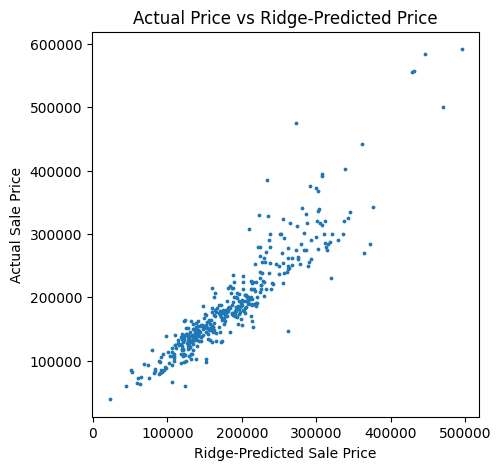

In [31]:
ridge_pred = ridge.predict(Xs_val)

ridge_resid = y_val - ridge_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(ridge_pred, y_val, s=3)
ax.set_title('Actual Price vs Ridge-Predicted Price')
ax.set_xlabel('Ridge-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

This scatterplot of the Ridge model's predicted prices vs. the actual price is also the most tightly clustered around y = x, which helps to visualize the similarity between the predicted and true values.

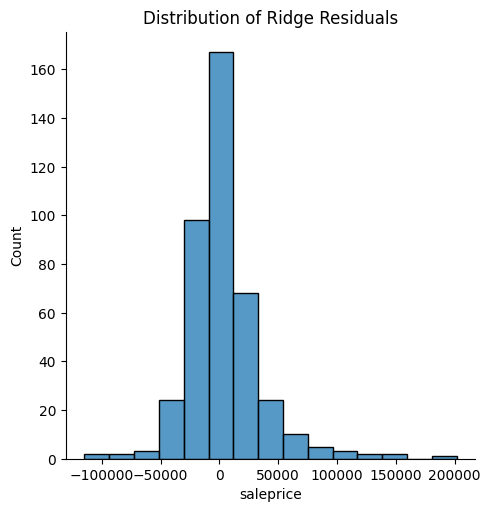

In [32]:
sns.displot(data=ridge_resid, bins=15).set(title='Distribution of Ridge Residuals');

### Lasso Model

In [33]:
lasso = LassoCV(alphas = np.arange(0.001, 10, 1))

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lasso.fit(Xs_train, y_train)

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(lasso, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.983051
Testing score                        0.611904
Training cross-validation score      0.568092
Testing cross-validation score       0.326622
Training RMSE score              10230.349140
Testing RMSE score               50723.095720


This time, the Lasso model received a score over 98% for the training data. However, the model scored poorly on the testing data, and even worse when scored using 5-fold cross-validation. From this, we can tell that the Lasso model is extremely overfit to the training data and does not generalize to other data.

In [36]:
lasso.alpha_

9.000999999999998

''

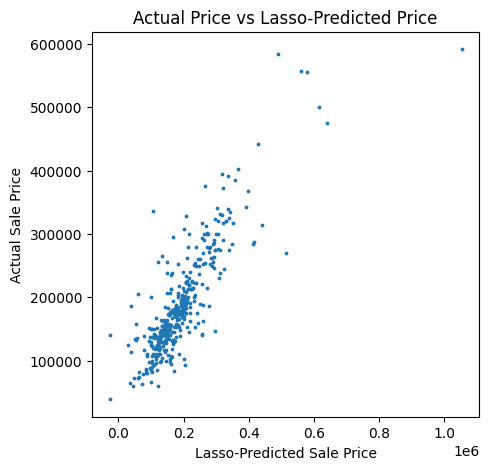

In [37]:
lasso_pred = lasso.predict(Xs_val)

lasso_resid = y_val - lasso_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(lasso_pred, y_val, s=3)
ax.set_title('Actual Price vs Lasso-Predicted Price')
ax.set_xlabel('Lasso-Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

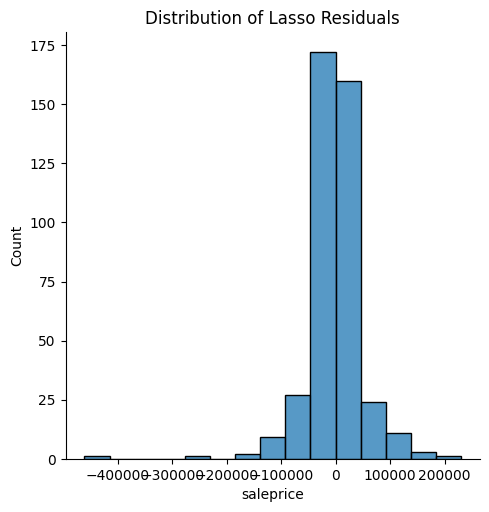

In [38]:
sns.displot(data=lasso_resid, bins=15).set(title='Distribution of Lasso Residuals');

### ElasticNet Model

In [39]:
enet = ElasticNetCV(
    l1_ratio=0.3, 
    alphas = np.arange(0.006, 0.01, 0.001))

In [40]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    enet.fit(Xs_train, y_train)

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    print(model_outputs(enet, Xs_train, Xs_val, y_train, y_val))

                                        score
Training score                       0.981151
Testing score                        0.717206
Training cross-validation score      0.645942
Testing cross-validation score       0.566889
Training RMSE score              10788.611712
Testing RMSE score               43298.318822


As expected, since the ElasticNet model combines the Ridge and Lasso models, it suffers from the same pitfalls as the Lasso model. While it does perform slightly better than the Lasso model, it is still highly overfit, and does not generalize well.

In [42]:
enet.alpha_

0.007

''

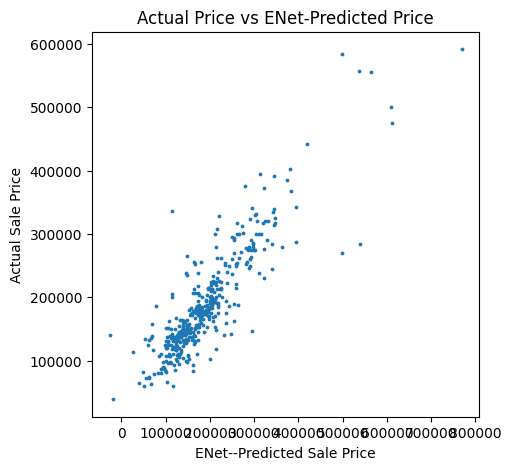

In [43]:
enet_pred = enet.predict(Xs_val)

enet_resid = y_val - enet_pred

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(enet_pred, y_val, s=3)
ax.set_title('Actual Price vs ENet-Predicted Price')
ax.set_xlabel('ENet--Predicted Sale Price')
ax.set_ylabel('Actual Sale Price')
;

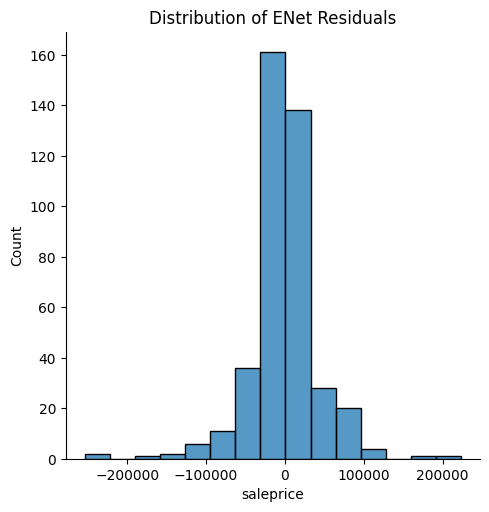

In [44]:
sns.displot(data=enet_resid, bins=15).set(title='Distribution of ENet Residuals');

### Predictions

In [45]:
df_test.head(1)

,id,pid,ms_subclass,ms_zoning,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,9142,Pave,Reg,Lvl,AllPub,Inside,...,0,60,112,0,0,0,0,4,2006,WD


In [46]:
test_id = new_df_test['id']

In [47]:
new_df_test = poly.transform(new_df_test.drop(columns ='id'))

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # preprocessed with standard scalar
    Xs_test = pd.DataFrame(
        ss.transform(new_df_test),
        columns = poly.get_feature_names_out()
    )

In [49]:
ridge_sub = Ridge(alpha = ridge.alpha_)

In [50]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #fit
    ridge_sub.fit(Xs_train, y_train)

In [51]:
preds = ridge_sub.predict(Xs_test)

In [52]:
preds = pd.DataFrame({'Id': test_id, 'Saleprice': preds})

In [53]:
preds.head()

,Id,Saleprice
0,2658,117549.571786
1,2718,156583.948858
2,2414,201028.529846
3,1989,102033.418305
4,625,175007.593292


In [54]:
preds.to_csv('../prediction_results/ridge_2_complex.csv', index=False)